# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


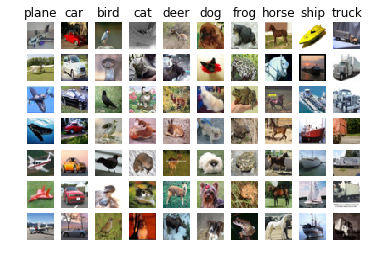

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


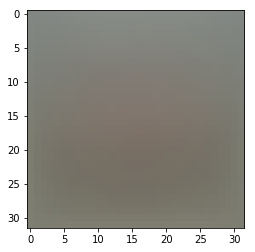

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data (broadcasting)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W. (Useful trick)
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [7]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))
grad

loss: 9.007978


array([[-1.92089185e+01, -1.10720269e+01,  5.60725694e+00, ...,
        -6.99824529e-01, -2.28056902e+01, -5.49628111e+01],
       [-3.29471690e+01, -9.74451143e+00,  3.51345204e+00, ...,
        -2.04137898e+00, -3.38068218e+01, -5.37471233e+01],
       [-5.28116692e+01, -1.45827303e+01,  2.09382176e+01, ...,
        -4.06411322e+00, -5.39644618e+01, -6.14667481e+01],
       ...,
       [-1.88428346e+01, -3.91986514e+00,  1.00778588e+01, ...,
         1.30786934e+01,  2.38601910e+00, -2.44853740e+01],
       [-3.42704274e+01, -7.59881200e+00,  2.21559871e+01, ...,
         2.56524146e+01, -1.47935254e+01, -2.78171794e+01],
       [-6.40000004e-02, -2.79999993e-02, -3.00000005e-02, ...,
         3.40000015e-02,  1.74000000e-01,  4.80000003e-02]])

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -21.351440 analytic: -21.351440, relative error: 3.421024e-12
numerical: 1.489078 analytic: 1.489078, relative error: 3.129051e-10
numerical: -3.542236 analytic: -3.448716, relative error: 1.337725e-02
numerical: 6.549715 analytic: 6.601044, relative error: 3.903119e-03
numerical: 0.293208 analytic: 0.293208, relative error: 1.885826e-09
numerical: 13.988123 analytic: 13.988123, relative error: 4.181475e-12
numerical: 19.103324 analytic: 19.103324, relative error: 3.617186e-13
numerical: -14.958070 analytic: -14.996864, relative error: 1.295092e-03
numerical: -1.226650 analytic: -1.226650, relative error: 1.965207e-10
numerical: 1.720494 analytic: 1.720494, relative error: 2.393070e-11
numerical: 12.555916 analytic: 12.555916, relative error: 3.715435e-12
numerical: -3.602764 analytic: -3.602764, relative error: 7.410699e-11
numerical: 2.750856 analytic: 2.750856, relative error: 2.173511e-10
numerical: 38.304254 analytic: 38.202937, relative error: 1.324286e-03
numerical: -

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *The SVM loss function is not strictly speaking differentiable. The point is at the very hinge of the loss function. e.g., for f(x) = max(-x,0) at x=0, there is no real gradient, numerical gradient would be close to 0 at 0.001, and close to 1 at -0.001*  



In [9]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.007978e+00 computed in 0.289574s
Vectorized loss: 9.007978e+00 computed in 0.259147s
difference: -0.000000


In [10]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)


Naive loss and gradient: computed in 0.379044s
Vectorized loss and gradient: computed in 0.310189s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [11]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, batch_size=200, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 793.210761
iteration 100 / 1500: loss 289.811993
iteration 200 / 1500: loss 108.932294
iteration 300 / 1500: loss 42.837112
iteration 400 / 1500: loss 18.765405
iteration 500 / 1500: loss 10.005831
iteration 600 / 1500: loss 7.102471
iteration 700 / 1500: loss 5.769521
iteration 800 / 1500: loss 5.595585
iteration 900 / 1500: loss 5.512250
iteration 1000 / 1500: loss 4.824638
iteration 1100 / 1500: loss 5.319081
iteration 1200 / 1500: loss 5.219767
iteration 1300 / 1500: loss 5.150323
iteration 1400 / 1500: loss 5.527998
That took 108.058559s


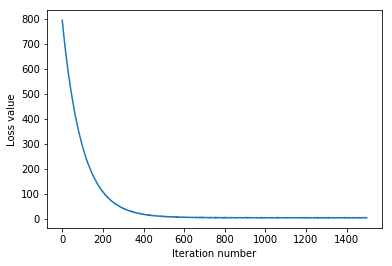

In [12]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [13]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.367776
validation accuracy: 0.390000


In [14]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

# learning_rates = np.array([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
learning_rates = 10 ** np.arange(-8,-1,0.5)
regularization_strengths = np.append([1,5], np.arange(10,100,10))
regularization_strengths = np.append(regularization_strengths, np.arange(100,2000,100))
print('learning_rates: ', learning_rates)
print('regularization_strengths: ', regularization_strengths)

learning_rates:  [1.00000000e-08 3.16227766e-08 1.00000000e-07 3.16227766e-07
 1.00000000e-06 3.16227766e-06 1.00000000e-05 3.16227766e-05
 1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02]
regularization_strengths:  [   1    5   10   20   30   40   50   60   70   80   90  100  200  300
  400  500  600  700  800  900 1000 1100 1200 1300 1400 1500 1600 1700
 1800 1900]


In [15]:
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = 0   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from copy import deepcopy
num_lr = learning_rates.shape[0]
num_reg = regularization_strengths.shape[0]
num_iters = 2000
loss_hist_val = np.zeros((num_lr*num_reg, num_iters))
counter = 0  # initialize counter

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()  # define a new object of class: LinearSVM
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=num_iters, batch_size=200, verbose=False)
        
        # keep trace of hyperparameters tunning
        loss_hist_val[counter, :] = loss_hist
        counter += 1
        
        # predict labels on training and validation set
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        print('learning_rate: %.8f, reg: %d' % (lr,reg))
        print('             training accuracy: %f' % (train_accuracy, ))
        print('             validation accuracy: %f' % (val_accuracy, ))
        
        # update the best parameters and save the best SVM classifier
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_setting = (lr,reg)
            best_svm = deepcopy(svm) # copy an instance of class
        
        # save result
        key = (lr,reg)
        results[key] = (train_accuracy, val_accuracy)
        
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    

learning_rate: 0.00000001, reg: 1
             training accuracy: 0.230490
             validation accuracy: 0.238000
learning_rate: 0.00000001, reg: 5
             training accuracy: 0.227143
             validation accuracy: 0.247000
learning_rate: 0.00000001, reg: 10
             training accuracy: 0.235633
             validation accuracy: 0.246000
learning_rate: 0.00000001, reg: 20
             training accuracy: 0.229633
             validation accuracy: 0.227000
learning_rate: 0.00000001, reg: 30
             training accuracy: 0.235571
             validation accuracy: 0.243000
learning_rate: 0.00000001, reg: 40
             training accuracy: 0.229551
             validation accuracy: 0.236000
learning_rate: 0.00000001, reg: 50
             training accuracy: 0.231122
             validation accuracy: 0.220000
learning_rate: 0.00000001, reg: 60
             training accuracy: 0.230531
             validation accuracy: 0.232000
learning_rate: 0.00000001, reg: 70
             tr

learning_rate: 0.00000010, reg: 80
             training accuracy: 0.319306
             validation accuracy: 0.315000
learning_rate: 0.00000010, reg: 90
             training accuracy: 0.319000
             validation accuracy: 0.335000
learning_rate: 0.00000010, reg: 100
             training accuracy: 0.311061
             validation accuracy: 0.311000
learning_rate: 0.00000010, reg: 200
             training accuracy: 0.313939
             validation accuracy: 0.309000
learning_rate: 0.00000010, reg: 300
             training accuracy: 0.319980
             validation accuracy: 0.327000
learning_rate: 0.00000010, reg: 400
             training accuracy: 0.321735
             validation accuracy: 0.315000
learning_rate: 0.00000010, reg: 500
             training accuracy: 0.325612
             validation accuracy: 0.304000
learning_rate: 0.00000010, reg: 600
             training accuracy: 0.323694
             validation accuracy: 0.327000
learning_rate: 0.00000010, reg: 700
      

learning_rate: 0.00000100, reg: 800
             training accuracy: 0.328592
             validation accuracy: 0.323000
learning_rate: 0.00000100, reg: 900
             training accuracy: 0.366571
             validation accuracy: 0.359000
learning_rate: 0.00000100, reg: 1000
             training accuracy: 0.364286
             validation accuracy: 0.364000
learning_rate: 0.00000100, reg: 1100
             training accuracy: 0.364857
             validation accuracy: 0.358000
learning_rate: 0.00000100, reg: 1200
             training accuracy: 0.361633
             validation accuracy: 0.345000
learning_rate: 0.00000100, reg: 1300
             training accuracy: 0.363041
             validation accuracy: 0.370000
learning_rate: 0.00000100, reg: 1400
             training accuracy: 0.350612
             validation accuracy: 0.351000
learning_rate: 0.00000100, reg: 1500
             training accuracy: 0.349102
             validation accuracy: 0.342000
learning_rate: 0.00000100, reg: 16

learning_rate: 0.00001000, reg: 1700
             training accuracy: 0.238102
             validation accuracy: 0.242000
learning_rate: 0.00001000, reg: 1800
             training accuracy: 0.240571
             validation accuracy: 0.258000
learning_rate: 0.00001000, reg: 1900
             training accuracy: 0.263980
             validation accuracy: 0.262000
learning_rate: 0.00003162, reg: 1
             training accuracy: 0.347592
             validation accuracy: 0.341000
learning_rate: 0.00003162, reg: 5
             training accuracy: 0.316367
             validation accuracy: 0.302000
learning_rate: 0.00003162, reg: 10
             training accuracy: 0.278286
             validation accuracy: 0.273000
learning_rate: 0.00003162, reg: 20
             training accuracy: 0.257469
             validation accuracy: 0.246000
learning_rate: 0.00003162, reg: 30
             training accuracy: 0.275735
             validation accuracy: 0.276000
learning_rate: 0.00003162, reg: 40
         

learning_rate: 0.00031623, reg: 50
             training accuracy: 0.239959
             validation accuracy: 0.250000
learning_rate: 0.00031623, reg: 60
             training accuracy: 0.260490
             validation accuracy: 0.273000
learning_rate: 0.00031623, reg: 70
             training accuracy: 0.220184
             validation accuracy: 0.207000
learning_rate: 0.00031623, reg: 80
             training accuracy: 0.226571
             validation accuracy: 0.223000
learning_rate: 0.00031623, reg: 90
             training accuracy: 0.236184
             validation accuracy: 0.232000
learning_rate: 0.00031623, reg: 100
             training accuracy: 0.212449
             validation accuracy: 0.217000
learning_rate: 0.00031623, reg: 200
             training accuracy: 0.205367
             validation accuracy: 0.202000
learning_rate: 0.00031623, reg: 300
             training accuracy: 0.189449
             validation accuracy: 0.190000
learning_rate: 0.00031623, reg: 400
         

/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_svm.py:99: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)  # add reg loss
/home/vincent/anaconda3/envs/cs231n/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


learning_rate: 0.00100000, reg: 1100
             training accuracy: 0.052633
             validation accuracy: 0.049000
learning_rate: 0.00100000, reg: 1200
             training accuracy: 0.051061
             validation accuracy: 0.052000


/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_svm.py:91: RuntimeWarning: overflow encountered in subtract
  margin_tmp = scores - correct_class_score + 1
/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_svm.py:91: RuntimeWarning: invalid value encountered in subtract
  margin_tmp = scores - correct_class_score + 1
/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_svm.py:97: RuntimeWarning: invalid value encountered in less
  margin[margin < 0] = 0
/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_svm.py:120: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_classifier.py:78: RuntimeWarning: invalid value encountered in subtract
  self.W -= learning_rate * grad


learning_rate: 0.00100000, reg: 1300
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.00100000, reg: 1400
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.00100000, reg: 1500
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.00100000, reg: 1600
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.00100000, reg: 1700
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.00100000, reg: 1800
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.00100000, reg: 1900
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.00316228, reg: 1
             training accuracy: 0.233449
             validation accuracy: 0.240000
learning_rate: 0.00316228, reg: 5
 

learning_rate: 0.03162278, reg: 10
             training accuracy: 0.173796
             validation accuracy: 0.185000
learning_rate: 0.03162278, reg: 20
             training accuracy: 0.164633
             validation accuracy: 0.161000
learning_rate: 0.03162278, reg: 30
             training accuracy: 0.054510
             validation accuracy: 0.055000
learning_rate: 0.03162278, reg: 40
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.03162278, reg: 50
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.03162278, reg: 60
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.03162278, reg: 70
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.03162278, reg: 80
             training accuracy: 0.100265
             validation accuracy: 0.087000
learning_rate: 0.03162278, reg: 90
             

In [16]:
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %d train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best: lr %e reg %d train accuarcy %f: ' % (best_setting[0], best_setting[1], best_val))

lr 1.000000e-08 reg 1 train accuracy: 0.230490 val accuracy: 0.238000
lr 1.000000e-08 reg 5 train accuracy: 0.227143 val accuracy: 0.247000
lr 1.000000e-08 reg 10 train accuracy: 0.235633 val accuracy: 0.246000
lr 1.000000e-08 reg 20 train accuracy: 0.229633 val accuracy: 0.227000
lr 1.000000e-08 reg 30 train accuracy: 0.235571 val accuracy: 0.243000
lr 1.000000e-08 reg 40 train accuracy: 0.229551 val accuracy: 0.236000
lr 1.000000e-08 reg 50 train accuracy: 0.231122 val accuracy: 0.220000
lr 1.000000e-08 reg 60 train accuracy: 0.230531 val accuracy: 0.232000
lr 1.000000e-08 reg 70 train accuracy: 0.232755 val accuracy: 0.249000
lr 1.000000e-08 reg 80 train accuracy: 0.234939 val accuracy: 0.248000
lr 1.000000e-08 reg 90 train accuracy: 0.230959 val accuracy: 0.235000
lr 1.000000e-08 reg 100 train accuracy: 0.236531 val accuracy: 0.226000
lr 1.000000e-08 reg 200 train accuracy: 0.234612 val accuracy: 0.253000
lr 1.000000e-08 reg 300 train accuracy: 0.235857 val accuracy: 0.253000
lr 1.

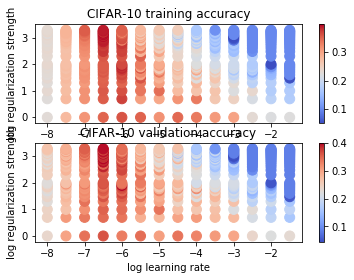

In [17]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [18]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.367000


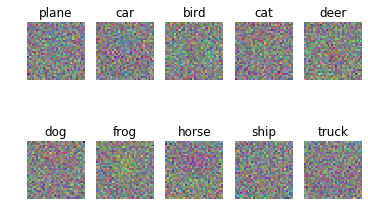

In [19]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
